# Fitting of two-step unfolding model to CD measurements of DNAJB6b at varying GdnHCl concentrations

Copyright © [2024] Technical University of Denmark

Prepared by Celia Fricke (celfri@dtu.dk) and Lars Boyens-Thiele (laksbo@dtu.dk)




November 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
from scipy.optimize import minimize

In [2]:
## Load data

# Load measurements and remove datapoints affected by absorbance by salt
df = pd.read_csv("denaturation_spectra_data_0to5M.txt", sep="\t")[:-6]
conc = np.array([0]+[float(s.split(" ")[0]) for s in df.columns[4:]] + [5.2])
Y = np.array(df.iloc[:, [3] + list(range(4, len(df.columns))) +  [1]]).T
M, N = Y.shape

In [3]:
## Function for calculating mixed spectra

def y_pred(s1, s2, s3, p, conc):
    """
    Arguments:
        s1: cd spectrum of native form
        s2: cd spectrum of intermediate form
        s3: cd spectrum of fully denatured form
        p: array of fitting parameters:
            m_I: m-value for first transition
            m_D: m-value for second transition
            CM_I: Midpoint denaturant concentration of first transition
            CM_D: Midpoint denaturant concentration of second transition
        conc: Denaturant concentration    
    """
    
    m_I, m_D, CM_I, CM_D = p
    
    # Calculate equilibrium constants
    K_I = np.exp(-m_I/8.314/298.15 * (CM_I-conc))
    K_D = np.exp(-m_D/8.314/298.15 * (CM_D-conc))

    # Calculate relative populations of the three species
    W = np.concatenate([1/(1+K_I+K_I*K_D), K_I/(1+K_I+K_I*K_D), K_I*K_D/(1+K_I+K_I*K_D)]).reshape((3, M)).T
    
    # Calculate and return the combined spectrum as a linear combination of the three pure spectra
    S = np.vstack([s1, s2, s3]).T 
    return W @ S.T

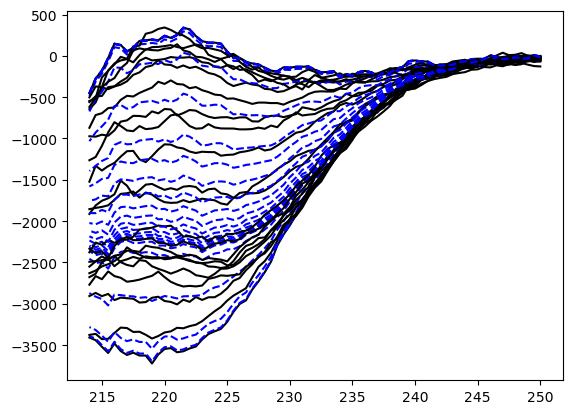

In [4]:
## Define and plot initial guess


# Initial points of the three pure spectra are the measured spectra at 0, 2.3, and 5.2 M 
s1 = np.array(df["100% native"])
s2 = np.array(df["2.3 M"])
s3 = np.array(df["0% native"])

# Initial points of the parameters m_I, m_D, CM_I, CM_D
p = [1e4, 1e4, 1.0, 3.0]

# Calculate spectra for initial guess
Y_pred = y_pred(s1, s2, s3, p, conc)

# Plot measured and calculated spectra
for i in range(M):
    plt.plot(df.wavelength, Y[i, :], color="k")
    plt.plot(df.wavelength, Y_pred[i, :], color="b", linestyle="dashed")
plt.show()

In [5]:
## Define cost function and perform least squares fitting

def cost_function(params, Y, conc, lambda_reg):
    # Get spectra from the array of parameters
    s1 = params[4:4+N].reshape((N,)) 
    s2 = params[4+N:4+2*N].reshape((N,))
    s3 = params[4+2*N:4+3*N].reshape((N,))

    # Calculate predicted spectra and the residual sum of squares to measured spectra
    Y_pred = y_pred(s1, s2, s3, params[:4], conc)
    rss = np.sum((Y - Y_pred) ** 2)
    
    # First-order Tikhonov regularization term for the three spectra
    regularization = lambda_reg*np.sum(np.array([np.diff(s)**2 for s in [s1, s2, s3]]))

    return rss + regularization

# Combined initial guess
p0 = np.concatenate([p, s1, s2, s3])

# Regularization strength
lambda_reg = 5 

# Minimize the cost function
result = minimize(cost_function, 
                      p0, 
                      args=(Y, conc, lambda_reg),
                     )

# Get optimal parameters and spectra
popt = result.x[:4]
s1_opt = result.x[4+0*N:4+1*N]
s2_opt = result.x[4+1*N:4+2*N]
s3_opt = result.x[4+2*N:4+3*N]


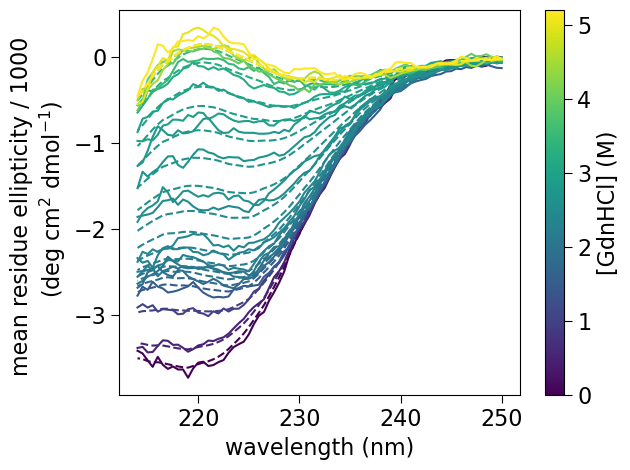

In [6]:
## Plot measured and fitted spectra

# Define colormap
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=5.2)  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Calculate and plot fitted spectra
Y_pred = y_pred(s1_opt, s2_opt, s3_opt, popt, conc)

for i in range(M):
    color = cmap(norm(conc[i]))
    plt.plot(df.wavelength, Y[i, :]/1000, color=color)
    plt.plot(df.wavelength, Y_pred[i, :]/1000, color=color, linestyle="dashed")

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('[GdnHCl] (M)', fontsize=16)
cbar.ax.tick_params(labelsize=16, length=6)
plt.xlabel('wavelength (nm)', fontsize=16)
plt.ylabel('mean residue ellipticity / 1000 \n (deg cm$^2$ dmol$^{-1}$)', fontsize = 16)
plt.tick_params(axis='both', length=6, labelsize=16)
plt.tight_layout()
plt.savefig('chem_denat_regularization_fits.pdf')
plt.show()


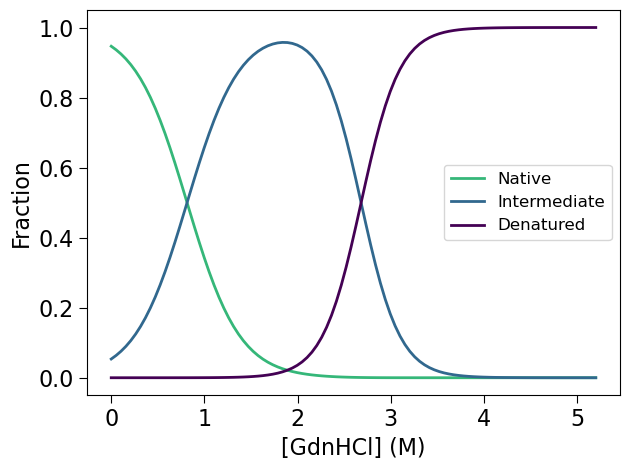

In [7]:
## Plot fractions of each population as a function of denaturant concentration

m_I, m_D, CM_I, CM_D = popt
xs = np.linspace(0, 5.2, 100)

# Calculate equilibrium constants at each denaturant concentration
ki = np.exp(-m_I/8.314/298.15 * (CM_I-xs))
kd = np.exp(-m_D/8.314/298.15 * (CM_D-xs))

# Calculate relative populations in the defined denaturant concentration range
W = np.concatenate([1/(1+ki+ki*kd), ki/(1+ki+ki*kd), ki*kd/(1+ki+ki*kd)]).reshape((3, 100)).T

# Plot the results
colors = ['#35b779','#31688e','#440154']
for i in range(3):
    plt.plot(xs, W.T[i], linewidth=2, color = colors[i])
    
plt.legend(["Native", "Intermediate", "Denatured"], fontsize=12)
plt.xlabel("[GdnHCl] (M)", fontsize = 16)
plt.ylabel("Fraction", fontsize = 16)
plt.tick_params(axis='both', length=6, labelsize=16)
plt.tight_layout()
plt.savefig('fractions_species_chemical_denaturation.pdf')
plt.show()